In [103]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import scipy.optimize as optimize

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [104]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [3]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
#     print(centroid_all.columns)
    centroid_above = centroid_all.loc[centroid_all.distance > 0]
    centroid_below = centroid_all.loc[centroid_all.distance == 0]
    del centroid_below['distance']
    misDistance = centroid_above.groupby(['origin']).agg({'distance':min})
    misDistance['distance'] = misDistance['distance']
    centroid_below = centroid_below.merge(misDistance,on=['origin'])
#     centroid_all.loc[centroid_all.distance == 0, 'distance'] = centroid_all.loc[centroid_all.distance > 0, 'distance'].min()*0.5
    centroid_all = pd.concat([centroid_above,centroid_below],axis=0)
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = city_network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [107]:
target_columns = ['SE03']
for city, state, conties in cities:
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
    training_set.to_csv('SE03/%s.csv'%city,index=False)
#     break

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


In [119]:
cities = os.listdir('cities/')

for city in cities:
    if '.csv' in city:
        df1 = pd.read_csv('SE01/%s'%city)
        df3 = pd.read_csv('SE03/%s'%city)
        df1.rename(columns={'jobs':'SE01jobs', 'residence':'SE01residence','flow':'SE01flow'}, inplace=True)
        df3.rename(columns={'jobs':'SE03jobs', 'residence':'SE03residence','flow':'SE03flow'}, inplace=True)
        df1.merge(df3,on=['origin','destination','distance'],how='outer').to_csv('income/%s'%city, index=False)

# baseline

### unconstrain model, power law

In [4]:

def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

# bucked unconstrained power law with distance

In [5]:


def power_law_k(x,a):
    return (x[:,0]**a)*x[:,1]*x[:,2]*x[:,3]

def fit_dist(data,target,k):
    data['k'] = k
    X = data[['distance', target+'jobs', target+'residence','k']].values
    y = data[target+'flow'].values
    pars, cov = optimize.curve_fit(f=power_law_k, xdata=X, ydata=y, bounds=(-np.inf, np.inf))
    return k,pars[0]

def fit_piece_power_law(data,target,k):
    bins_list = data['bin'].unique()    
    bin_to_model = {}
    for b in bins_list:
        subData = data[data['bin'] == b]
        model = fit_dist(subData,target,k)
#         k = model[0]
        bin_to_model[b] = model[1]
        
    return [k,bin_to_model]

def predict_piece_powerlaw(data,target,model):
    k = model[0]
    bin_to_model =  model[1]
    data[target+'a'] = data['bin'].apply(lambda x:bin_to_model[x]).astype(float)
    data[target+'pred'] = (data['distance']**data[target+'a'])*data[target+'jobs']*data[target+'residence']*k
    return data

## Normalize bin

In [19]:
cities = os.listdir('cities/')
citiesDir = 'cities/'
import seaborn as sns

In [21]:
np.log(df.distance)

0          0.559401
1          1.674769
2          2.912625
3          2.837102
4          3.583228
             ...   
5480276    2.003293
5480277   -0.165346
5480278    0.227176
5480279   -1.094151
5480280   -0.245902
Name: distance, Length: 5480281, dtype: float64

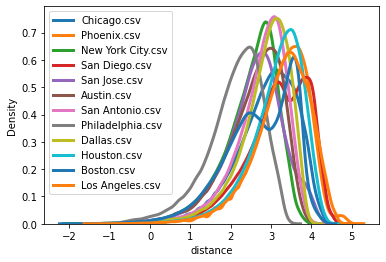

In [20]:
for city in cities:
    if '.csv' in city:
        df = pd.read_csv(citiesDir+city)
        sns.distplot(np.log(df.distance), hist = False, kde = True,
             kde_kws = {'linewidth': 3},
             label = city)
plt.legend()

In [24]:
minValue = []
maxValue = []
for city in cities:
    if '.csv' in city:
        df = pd.read_csv(citiesDir+city)
        minValue += [np.min(np.log(df.distance))]
        maxValue += [np.max(np.log(df.distance))]
minValue = np.min(minValue)
maxValue = np.max(maxValue)
print(minValue,maxValue)

-2.120014812572229 5.2031663975706754


In [30]:
distBin = np.linspace(minValue,maxValue,41)
distBin

array([-2.12001481, -1.93693528, -1.75385575, -1.57077622, -1.38769669,
       -1.20461716, -1.02153763, -0.8384581 , -0.65537857, -0.47229904,
       -0.28921951, -0.10613998,  0.07693955,  0.26001908,  0.44309861,
        0.62617814,  0.80925767,  0.9923372 ,  1.17541673,  1.35849626,
        1.54157579,  1.72465532,  1.90773485,  2.09081438,  2.27389391,
        2.45697344,  2.64005297,  2.8231325 ,  3.00621203,  3.18929156,
        3.3723711 ,  3.55545063,  3.73853016,  3.92160969,  4.10468922,
        4.28776875,  4.47084828,  4.65392781,  4.83700734,  5.02008687,
        5.2031664 ])

In [75]:
def locBin(x,distBin):
    if x >= distBin[0] and x <= distBin[-1]:
        for i,num in enumerate(distBin):
            if x >= distBin[i] and x<= distBin[i+1]:
                return i
    else:
        return 'error'

In [77]:

resultsfd = {}
cities = os.listdir('cities/')
citiesDir = 'cities/'
target = 'S000'

for bins in np.arange(10,200,10):
    print(bins,end='\r')
    for city in cities:
        if '.csv' in city:
            df = pd.read_csv(citiesDir+city)
            df['logDist'] = np.log(df['distance'])
            distBin = np.linspace(minValue,maxValue,bins+1)
            df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
            df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
            df['bin'] = df['bin'].astype(str)



            binfdf = pd.DataFrame()

            # fd
            k = 1
            binf = unconstrained_bucked_constant_kfit(df, target,k)
            df_fd = unconstrained_bucked_constant_predict(df,target,k,binf)
            binfd = pd.DataFrame({'bin':binf.keys(),'f(d)':binf.values()})
            resultsfd[city] = resultsfd.get(city,[]) + [mean_squared_error(df_fd[target+'flow'],df_fd[target+'pred'])]
            

### apply bins to insample

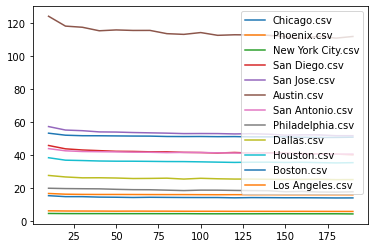

In [80]:
for city in cities:
    if '.csv' in city:
        plt.plot(np.arange(10,200,10),resultsfd[city],label=city)
plt.legend()

Text(0.5, 0, 'bins')

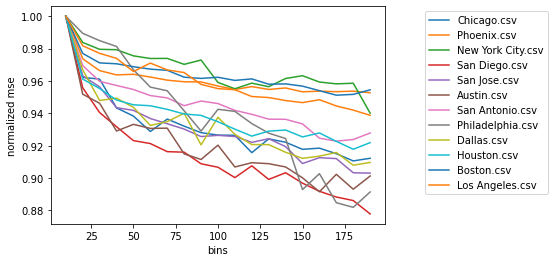

In [144]:
for city in cities:
    if '.csv' in city:
        mse = np.array(resultsfd[city])
        mse = mse/np.max(mse)
        plt.plot(np.arange(10,200,10),mse,label=city)
plt.legend(bbox_to_anchor=(1, 0.5,0.5, 0.5))
plt.ylabel('normalized mse')
plt.xlabel('bins')

In [89]:
# arbitarily set bin=40
resultsBaseline = {}
resultsfd40 = {}
bindffDict = {}
cities = os.listdir('cities/')
citiesDir = 'cities/'
target = 'S000'
bins = 40
for city in cities:
    if '.csv' in city:
        print(city)
        df = pd.read_csv(citiesDir+city)
        df['logDist'] = np.log(df['distance'])
        distBin = np.linspace(minValue,maxValue,bins+1)
        df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        df['bin'] = df['bin'].astype(str)
        
        

        binfdf = pd.DataFrame()
        
        # fd
        k = 1
        binf = unconstrained_bucked_constant_kfit(df, target,k)
        df_fd = unconstrained_bucked_constant_predict(df,target,k,binf)
        binfd = pd.DataFrame({'bin':binf.keys(),'f(d)':binf.values()})
        bindffDict[city] = binfd
        resultsfd40[city] = mean_squared_error(df_fd[target+'flow'],df_fd[target+'pred'])
        
        # baseline 
        pars = baseline_fit(df,target)
        df_baseline = baseline_predict(df,target,pars)
        resultsBaseline[city] = mean_squared_error(df_baseline[target+'flow'],df_baseline[target+'pred'])

Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv


In [90]:
pd.DataFrame({'city':resultsfd40.keys(),
              'baseline': list(resultsBaseline.values()),
            'f(d) MSE':list(resultsfd40.values())})


,city,baseline,f(d) MSE
0,Chicago.csv,15.424961,14.529367
1,Phoenix.csv,16.303593,16.133596
2,New York City.csv,4.542374,4.506581
3,San Diego.csv,44.659759,42.748369
4,San Jose.csv,55.477283,54.127754
5,Austin.csv,119.110002,115.536740
6,San Antonio.csv,42.478040,42.100795
7,Philadelphia.csv,20.559021,19.547786
8,Dallas.csv,26.866982,26.284172
9,Houston.csv,37.132907,36.458497


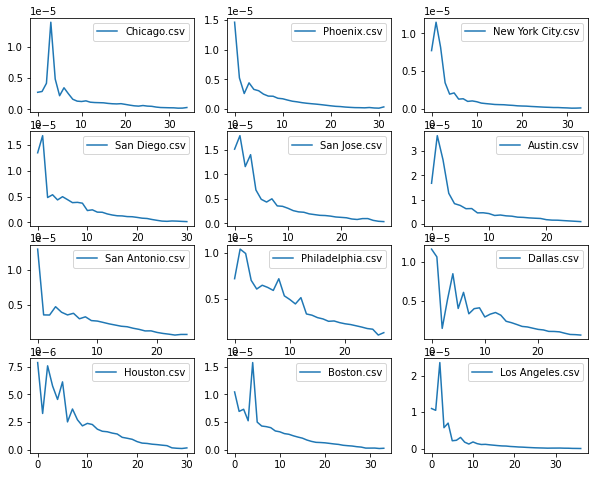

In [96]:
fig,ax = plt.subplots(4,3,figsize=(10,8))
i= 0
for city in cities:
    if '.csv' in city:
        df = bindffDict[city]
        df['bin'] = df['bin'].astype(int)
        df = df.sort_values(by='bin')
        ax[i//3,i%3].plot(range(len(df)),df['f(d)'],label=city)
        ax[i//3,i%3].legend()
        i += 1
        

In [148]:
%%time
# arbitarily set bin=40

resultsfd40 = {}
bindffDict = {}
bins = 40
for city in cities:
    if '.csv' in city:
        print(city)
        df = pd.read_csv('income/'+city)
        df['logDist'] = np.log(df['distance'])
        distBin = np.linspace(minValue,maxValue,bins+1)
        df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
        df['bin'] = df['bin'].astype(str)
        
        

        binfdf = pd.DataFrame()
        
        # fd
        k = 1
        for target in ['SE01','SE03']:
            binf = unconstrained_bucked_constant_kfit(df, target,k)
            df_fd = unconstrained_bucked_constant_predict(df,target,k,binf)
            bindffDict[city] = bindffDict.get(city,[]) + [binf]
            resultsfd40[city] = resultsfd40.get(city,[])+ \
                    [mean_squared_error(df_fd[target+'flow'],df_fd[target+'pred'])]

Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv
CPU times: user 3min 32s, sys: 3min 5s, total: 6min 37s
Wall time: 2min 50s


In [149]:
%%time

resultsBaseline = {}
bins = 40
for city in cities:
    if '.csv' in city:
        print(city)
        df = pd.read_csv('income/'+city)
        df['logDist'] = np.log(df['distance'])
        distBin = np.linspace(minValue,maxValue,bins+1)
        df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
        df.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
        df['bin'] = df['bin'].astype(str)
        
        

        binfdf = pd.DataFrame()
        
        # fd
        k = 1
        for target in ['SE01','SE03']:
            binf = unconstrained_bucked_constant_kfit(df, target,k)
            df_fd = unconstrained_bucked_constant_predict(df,target,k,binf)
            bindffDict[city] = bindffDict.get(city,[]) + [binf]
            resultsfd40[city] = resultsfd40.get(city,[])+ \
                    [mean_squared_error(df_fd[target+'flow'],df_fd[target+'pred'])]

            # baseline 
            pars = baseline_fit(df,target)
            df_baseline = baseline_predict(df,target,pars)
            resultsBaseline[city] = resultsBaseline.get(city,[]) + \
                [mean_squared_error(df_baseline[target+'flow'],df_baseline[target+'pred'])]

Chicago.csv
Phoenix.csv
New York City.csv
San Diego.csv
San Jose.csv
Austin.csv
San Antonio.csv
Philadelphia.csv
Dallas.csv
Houston.csv
Boston.csv
Los Angeles.csv
CPU times: user 3min 50s, sys: 3min 8s, total: 6min 58s
Wall time: 3min 10s


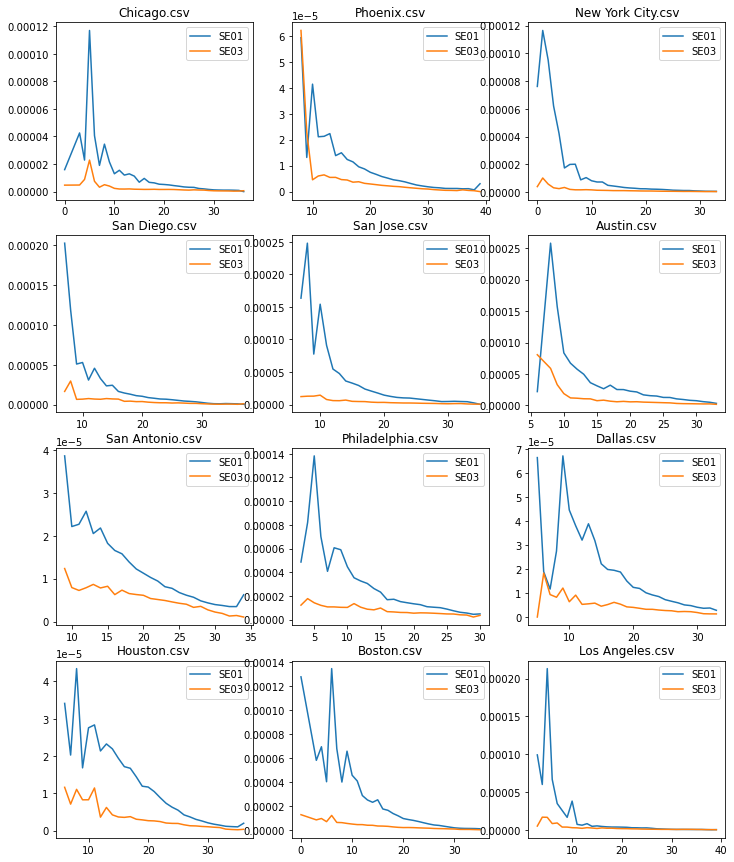

In [136]:
fig,ax = plt.subplots(4,3,figsize=(12,15))
i= 0
for city in cities:
    if '.csv' in city:
        df = pd.DataFrame({'bin':bindffDict[city][0].keys(),'fd':bindffDict[city][0].values()})
        df['bin'] = df['bin'].astype(int)
        df = df.sort_values(by='bin')
        ax[i//3,i%3].plot(df['bin'],df['fd'],label='SE01')
        
        df = pd.DataFrame({'bin':bindffDict[city][1].keys(),'fd':bindffDict[city][1].values()})
        df['bin'] = df['bin'].astype(int)
        df = df.sort_values(by='bin')
        ax[i//3,i%3].plot(df['bin'],df['fd'],label='SE03')
        
        ax[i//3,i%3].set_title(city)
        ax[i//3,i%3].legend()
        i += 1
        

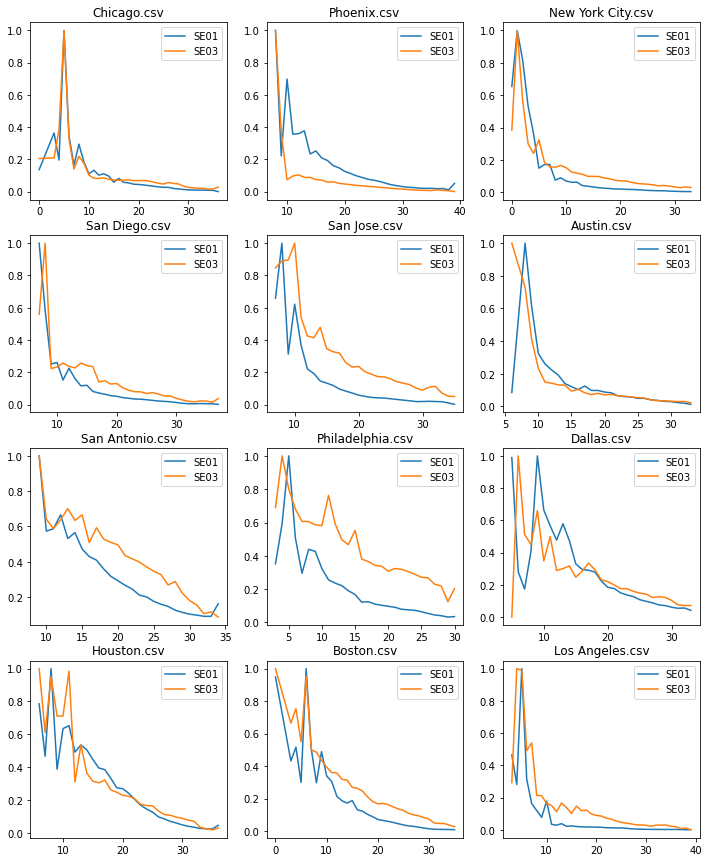

In [137]:
fig,ax = plt.subplots(4,3,figsize=(12,15))
i= 0
for city in cities:
    if '.csv' in city:
        df = pd.DataFrame({'bin':bindffDict[city][0].keys(),'fd':bindffDict[city][0].values()})
        df['bin'] = df['bin'].astype(int)
        df = df.sort_values(by='bin')
        ax[i//3,i%3].plot(df['bin'],df['fd']/df['fd'].max(),label='SE01')
        
        df = pd.DataFrame({'bin':bindffDict[city][1].keys(),'fd':bindffDict[city][1].values()})
        df['bin'] = df['bin'].astype(int)
        df = df.sort_values(by='bin')
        ax[i//3,i%3].plot(df['bin'],df['fd']/df['fd'].max(),label='SE03')
        
        ax[i//3,i%3].set_title(city)
        ax[i//3,i%3].legend()
        i += 1
        

In [159]:
pd.DataFrame({'city':resultsfd40.keys(),
              'SE01 baseline': np.array(list(resultsBaseline.values()))[:,0],
            'SE01 f(d)': np.array(list(resultsfd40.values()))[:,0],
              'SE03 baseline': np.array(list(resultsBaseline.values()))[:,1],

             'SE03 f(d)': np.array(list(resultsfd40.values()))[:,1]})

,city,SE01 baseline,SE01 f(d),SE03 baseline,SE03 f(d)
0,Chicago.csv,1.066591,1.055532,6.834734,5.927030
1,Phoenix.csv,1.350065,1.341431,5.380550,5.276428
2,New York City.csv,0.462500,0.451297,1.837383,1.821439
3,San Diego.csv,2.698169,2.652514,16.117691,15.199191
4,San Jose.csv,2.866874,2.783777,30.580614,30.009145
5,Austin.csv,6.904670,6.819776,44.382694,42.374652
6,San Antonio.csv,3.269780,3.268558,14.224390,13.925388
7,Philadelphia.csv,1.488716,1.461050,8.263004,7.656797
8,Dallas.csv,1.539351,1.531891,10.672541,10.399777
9,Houston.csv,1.698301,1.674191,14.919271,14.560554
